In [55]:

import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.tree import plot_tree
import time
import struct

[[20.88521861 10.46520059]
 [19.66404413 10.38922762]
 [19.27727307 10.77583899]
 ...
 [14.42800736 19.33074248]
 [15.23918759 19.5304279 ]
 [14.40755997 18.82980795]]


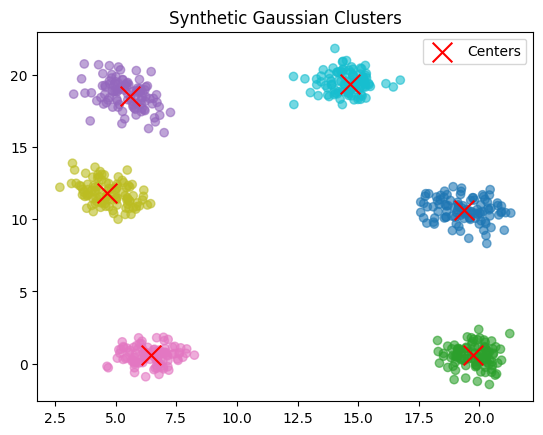

Les centres détéctés : [[19.38241673 10.65680879]
 [19.74452674  0.63070616]
 [ 5.59050659 18.48515404]
 [ 6.45342351  0.57560592]
 [ 4.65809323 11.79316613]
 [14.64823968 19.37290271]]


In [56]:
def generate_gaussian_clusters(n_clusters, n_samples_per_cluster):
    cluster_centers = []
    while len(cluster_centers) < n_clusters:
        candidate = np.random.uniform(0, 20, size=(2,))
        if all(np.linalg.norm(candidate - np.array(c)) >= 6 for c in cluster_centers):
            cluster_centers.append(candidate)
    
    cluster_centers = np.array(cluster_centers)
    data = []
    labels = []  # Ajout pour éviter l'erreur

    for i, center in enumerate(cluster_centers):
        variance_x = np.abs(np.random.normal(0.5, 0.15))  
        variance_y = np.abs(np.random.normal(0.5, 0.15))
        cov_value = np.random.exponential(scale=0.1) * np.random.choice([-1, 1])

        cov_matrix = np.array([[variance_x, cov_value], [cov_value, variance_y]])
        cov_matrix = (cov_matrix + cov_matrix.T) / 2  
        cov_matrix = cov_matrix + 1e-3 * np.eye(2)  

        if n_samples_per_cluster > 0:  # Éviter erreur si valeur est 0
            points = np.random.multivariate_normal(center, cov_matrix, n_samples_per_cluster)
            data.append(points)
            labels.extend([i] * n_samples_per_cluster)  # Assigner des labels aux points

    if len(data) > 0:
        data = np.vstack(data)
    else:
        data = np.array([])  # Retourne un tableau vide si aucune donnée générée

    return data, np.array(labels), cluster_centers

# Génération des données avec une valeur modifiable de `n_samples_per_cluster`
n_samples_per_cluster = 100
n_clusters = 6
data, labels, centers = generate_gaussian_clusters(n_clusters=n_clusters,n_samples_per_cluster=n_samples_per_cluster)

print(data)

# Vérification que des données existent avant l'affichage
if data.size > 0:
    plt.scatter(data[:, 0], data[:, 1], c=labels, cmap='tab10', alpha=0.6)
    plt.scatter(np.array(centers)[:, 0], np.array(centers)[:, 1], c='red', marker='x', s=200, label='Centers')
    plt.legend()
    plt.title("Synthetic Gaussian Clusters")
    plt.show()
else:
    print("Aucune donnée générée.")

print("Les centres détéctés :", centers)



Centres trouvés par K-Means :
[[ 5.44455511 18.61602735]
 [19.75740426  0.55889517]
 [19.36815203 10.62254585]
 [ 6.44193468  0.57154821]
 [14.54979355 19.44545125]
 [ 4.7111007  11.78303891]]

Inertie (somme des distances intra-cluster) : 735.4124
Score de silhouette : 0.8359

Temps d'exécution de K-Means : 0.0265 secondes


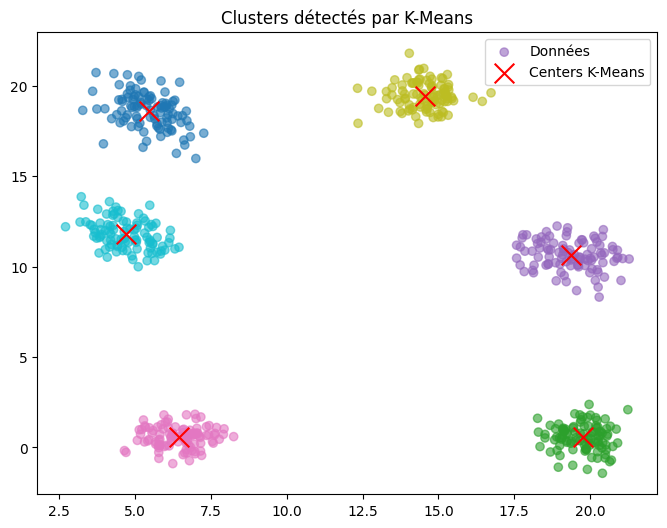

In [57]:
# Vérification qu'on a bien des données
if data.size > 0:
    # Mesurer le temps de calcul
    start_time = time.time()
    
    # Appliquer K-Means
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    labels_pred = kmeans.fit_predict(data)
    
    end_time = time.time()
    elapsed_time = end_time - start_time  # Temps en secondes

    # Affichage des coordonnées des centres trouvés par K-Means
    print("\nCentres trouvés par K-Means :")
    print(kmeans.cluster_centers_)

    # Calcul des performances de K-Means
    inertia = kmeans.inertia_  # Somme des distances intra-cluster
    print(f"\nInertie (somme des distances intra-cluster) : {inertia:.4f}")

    if n_clusters > 1:
        silhouette = silhouette_score(data, labels_pred)
        print(f"Score de silhouette : {silhouette:.4f}")

    print(f"\nTemps d'exécution de K-Means : {elapsed_time:.4f} secondes")

    # Visualisation des clusters détectés
    plt.figure(figsize=(8, 6))
    plt.scatter(data[:, 0], data[:, 1], c=labels_pred, cmap="tab10", alpha=0.6, label="Données")
    plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], c='red', marker='x', s=200, label="Centers K-Means")
    plt.legend()
    plt.title("Clusters détectés par K-Means")
    plt.show()
else:
    print("Aucune donnée générée.")

In [58]:
from ExKMC.Tree import Tree
from IPython.display import Image


In [59]:
def plot_tree_boundary(cluster_tree, k, x_data, kmeans, plot_mistakes=False):
    cmap = plt.cm.get_cmap('PuBuGn')
    
    ########### IMM leaves ###########
    plt.figure(figsize=(4, 4))
    
    x_min, x_max = x_data[:, 0].min() - 1, x_data[:, 0].max() + 1
    y_min, y_max = x_data[:, 1].min() - 1, x_data[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, .1),
                         np.arange(y_min, y_max, .1))

    values = np.c_[xx.ravel(), yy.ravel()]
    
    y_cluster_tree = cluster_tree.predict(x_data)

    Z = cluster_tree.predict(values)
    Z = Z.reshape(xx.shape)
    plt.imshow(Z, interpolation='nearest',
               extent=(xx.min(), xx.max(), yy.min(), yy.max()),
               cmap=cmap, 
               aspect='auto', origin='lower', alpha=0.4)


    plt.scatter([x[0] for x in x_data], [x[1] for x in x_data], c=y_cluster_tree, edgecolors='black', s=20, cmap=cmap)
    for c in range(k):
        center = x_data[y_cluster_tree==c].mean(axis=0)
        plt.scatter([center[0]], [center[1]], c="white", marker='$%s$' % c, s=350, linewidths=.5, zorder=10, edgecolors='black')
        
    if plot_mistakes:
        y = kmeans.predict(x_data)
        mistakes = x_data[y_cluster_tree != y]
        plt.scatter([x[0] for x in mistakes], [x[1] for x in mistakes], marker='x', c='red', s=60, edgecolors='black', cmap=cmap)

    plt.xticks([])
    plt.yticks([])
    plt.title("Approximation Ratio: %.2f" % (cluster_tree.score(x_data) / -kmeans.score(x_data)), fontsize=14)
    plt.show()

/var/folders/5_/x_n3x1nd2qz68t6ylmb7yrhc0000gn/T/ipykernel_58605/2309878381.py:32: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter([x[0] for x in mistakes], [x[1] for x in mistakes], marker='x', c='red', s=60, edgecolors='black', cmap=cmap)
/var/folders/5_/x_n3x1nd2qz68t6ylmb7yrhc0000gn/T/ipykernel_58605/2309878381.py:32: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter([x[0] for x in mistakes], [x[1] for x in mistakes], marker='x', c='red', s=60, edgecolors='black', cmap=cmap)


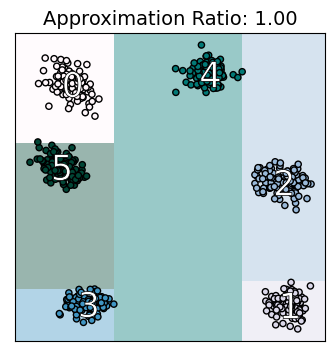

In [60]:
# IMM ALgorithm applied to the Kmean 

tree = Tree(k=n_clusters)      
tree.fit(data, kmeans)               
labels_imm = tree.predict(data)
plot_tree_boundary(tree,n_clusters, data, kmeans, plot_mistakes=True)


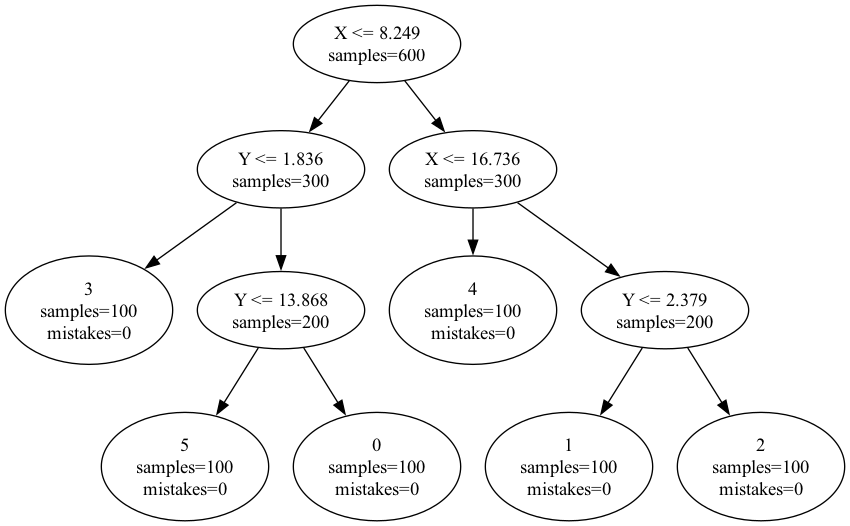

In [61]:
feature_Names = ['X', 'Y']
tree.plot(filename='test', feature_names=feature_Names)
Image(filename='test.gv.png')

[Text(0.5909090909090909, 0.875, 'x[0] <= 17.158\ngini = 0.833\nsamples = 600\nvalue = [100, 100, 100, 100, 100, 100]'),
 Text(0.36363636363636365, 0.625, 'x[1] <= 14.924\ngini = 0.75\nsamples = 400\nvalue = [100, 0, 0, 100, 100, 100]'),
 Text(0.4772727272727273, 0.75, 'True  '),
 Text(0.18181818181818182, 0.375, 'x[1] <= 5.915\ngini = 0.5\nsamples = 200\nvalue = [0, 0, 0, 100, 0, 100]'),
 Text(0.09090909090909091, 0.125, 'gini = 0.0\nsamples = 100\nvalue = [0, 0, 0, 100, 0, 0]'),
 Text(0.2727272727272727, 0.125, 'gini = 0.0\nsamples = 100\nvalue = [0, 0, 0, 0, 0, 100]'),
 Text(0.5454545454545454, 0.375, 'x[0] <= 9.798\ngini = 0.5\nsamples = 200\nvalue = [100, 0, 0, 0, 100, 0]'),
 Text(0.45454545454545453, 0.125, 'gini = 0.0\nsamples = 100\nvalue = [100, 0, 0, 0, 0, 0]'),
 Text(0.6363636363636364, 0.125, 'gini = 0.0\nsamples = 100\nvalue = [0, 0, 0, 0, 100, 0]'),
 Text(0.8181818181818182, 0.625, 'x[1] <= 5.348\ngini = 0.5\nsamples = 200\nvalue = [0, 100, 100, 0, 0, 0]'),
 Text(0.704545

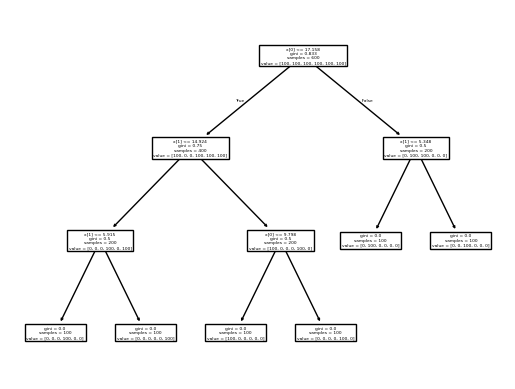

In [62]:
from sklearn import tree
clf = tree.DecisionTreeClassifier()
clf = clf.fit(data, labels_pred)
tree.plot_tree(clf)

Accuracy of Decision Tree: 1.0000


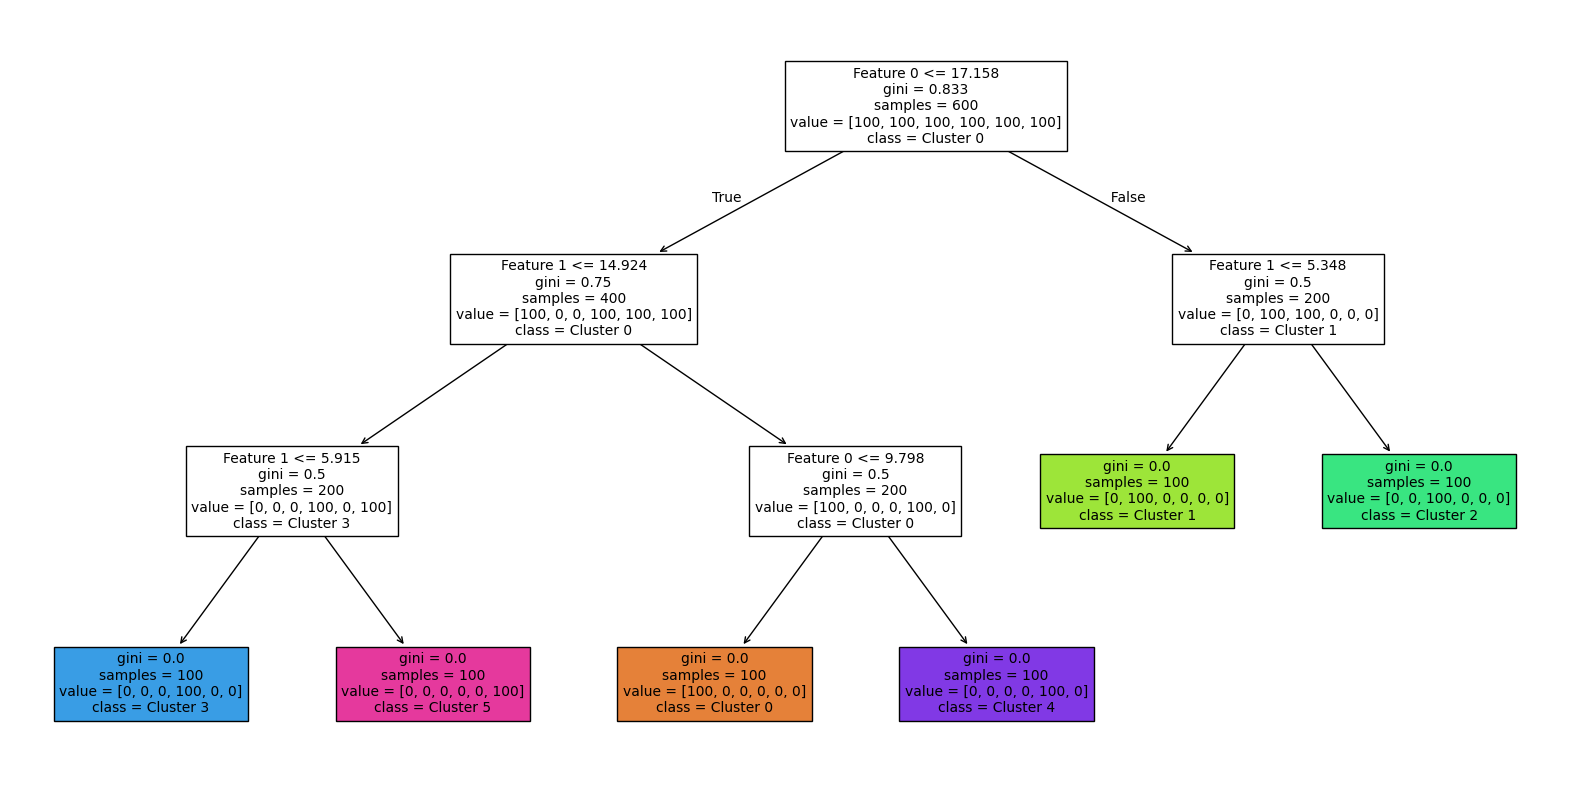

In [63]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score

# Train a Decision Tree Classifier
decision_tree = DecisionTreeClassifier(random_state=42)
decision_tree.fit(data, labels_pred)

# Evaluate the Decision Tree
labels_pred_dt = decision_tree.predict(data)
accuracy = accuracy_score(labels_pred, labels_pred_dt)
print(f"Accuracy of Decision Tree: {accuracy:.4f}")

# Visualize the Decision Tree
plt.figure(figsize=(20, 10))
plot_tree(decision_tree, filled=True, feature_names=[f"Feature {i}" for i in range(data.shape[1])], class_names=[f"Cluster {i}" for i in range(n_clusters)])
plt.show()

In [64]:
def find_optimal_clusters(data, max_clusters=15):
    inertias = []
    silhouette_scores = []
    
    for k in range(2, max_clusters + 1):
        # Fit K-Means
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        labels = kmeans.fit_predict(data)
        
        # Calcul des métriques
        inertias.append(kmeans.inertia_)
        silhouette_scores.append(silhouette_score(data, labels))
        
    return inertias, silhouette_scores

In [65]:
def plot_metrics(inertias, silhouette_scores):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    # Plot inertia
    ax1.plot(range(2, len(inertias) + 2), inertias, 'bo-')
    ax1.set_xlabel('Nombre de clusters')
    ax1.set_ylabel('Inertie')
    ax1.set_title('Méthode du coude')
    
    # Plot silhouette scores
    ax2.plot(range(2, len(silhouette_scores) + 2), silhouette_scores, 'ro-')
    ax2.set_xlabel('Nombre de clusters')
    ax2.set_ylabel('Score de silhouette')
    ax2.set_title('Scores de silhouette')
    
    plt.tight_layout()
    plt.show()

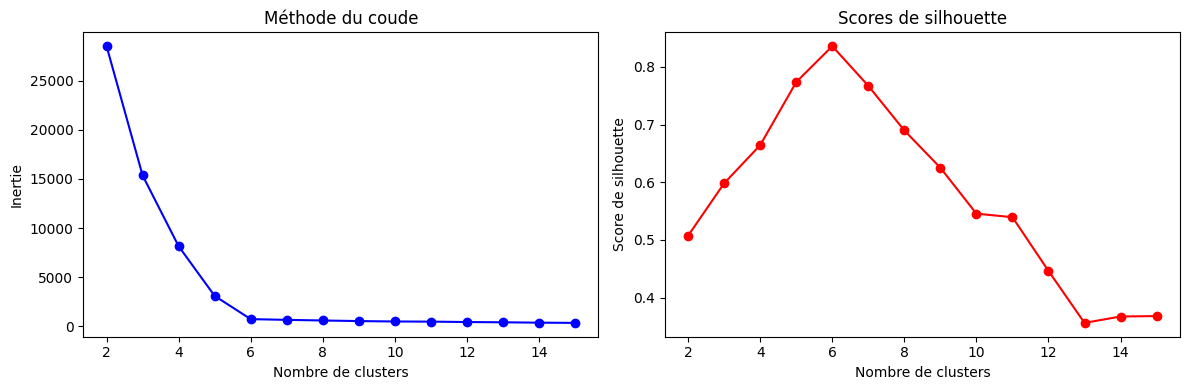

In [66]:
inertias, silhouette_scores = find_optimal_clusters(data, max_clusters=15)
plot_metrics(inertias, silhouette_scores)

In [67]:
def get_optimal_k_silhouette(silhouette_scores):
    """
    Retourne le nombre de clusters (k) qui maximise le score de silhouette.
    On suppose que silhouette_scores correspond à k allant de 2 à N.
    """
    best_index = np.argmax(silhouette_scores)
    optimal_k = best_index + 2  # car le premier score correspond à k=2
    return optimal_k

In [68]:
optimal_k = get_optimal_k_silhouette(silhouette_scores)
print("Nombre optimal de clusters (silhouette) :", optimal_k)

Nombre optimal de clusters (silhouette) : 6


In [69]:
# Fonction pour convertir un flottant en représentation IEEE 754 (32 bits)
def float_to_ieee754_bin(f):
    """Convertit un float en binaire IEEE 754 (32 bits)."""
    [binary] = struct.unpack(">I", struct.pack(">f", f))  # Conversion float → bits
    return np.array([int(bit) for bit in f"{binary:032b}"])  # Retourne une liste de 32 bits

# Initialisation des matrices
X = []
Y = []

if data.size > 0:
    for point in data:
        x_bin = float_to_ieee754_bin(point[0])
        y_bin = float_to_ieee754_bin(point[1])
        
        X.append(x_bin)  # Ajout de la représentation binaire de X
        Y.append(y_bin)  # Ajout de la représentation binaire de y
        print(point,x_bin)

# Conversion en numpy array
X = np.array(X)
Y = np.array(Y)

# Affichage des résultats
print("Matrice X (représentation IEEE 754 des flottants) :")
print(X[:5])

print("\nMatrice Y (valeurs associées en binaire IEEE 754) :")
print(Y[:5])


[20.88521861 10.46520059] [0 1 0 0 0 0 0 1 1 0 1 0 0 1 1 1 0 0 0 1 0 1 0 0 1 1 1 0 1 1 0 1]
[19.66404413 10.38922762] [0 1 0 0 0 0 0 1 1 0 0 1 1 1 0 1 0 1 0 0 1 1 1 1 1 1 1 1 0 1 1 0]
[19.27727307 10.77583899] [0 1 0 0 0 0 0 1 1 0 0 1 1 0 1 0 0 0 1 1 0 1 1 1 1 1 0 1 1 0 1 1]
[17.57997206 10.47102465] [0 1 0 0 0 0 0 1 1 0 0 0 1 1 0 0 1 0 1 0 0 0 1 1 1 1 0 0 1 0 0 0]
[21.29159606 10.42427761] [0 1 0 0 0 0 0 1 1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 1 0 0 1 1 0 0 0 0]
[19.09937181 10.65237841] [0 1 0 0 0 0 0 1 1 0 0 1 1 0 0 0 1 1 0 0 1 0 1 1 1 0 0 0 0 0 1 1]
[19.0446575   9.68190553] [0 1 0 0 0 0 0 1 1 0 0 1 1 0 0 0 0 1 0 1 1 0 1 1 0 1 1 1 0 1 0 1]
[20.41023559 11.67013017] [0 1 0 0 0 0 0 1 1 0 1 0 0 0 1 1 0 1 0 0 1 0 0 0 0 0 1 0 1 0 1 0]
[18.63326727 10.91674003] [0 1 0 0 0 0 0 1 1 0 0 1 0 1 0 1 0 0 0 1 0 0 0 0 1 1 1 0 1 1 1 0]
[20.05179342 10.35408923] [0 1 0 0 0 0 0 1 1 0 1 0 0 0 0 0 0 1 1 0 1 0 1 0 0 0 0 1 0 0 1 1]
[17.90990986 11.75909527] [0 1 0 0 0 0 0 1 1 0 0 0 1 1 1 1 0 1 0 0 0 1 1 1 0 1 1

In [70]:
def generalized_deduplication_compress(X, Y, base_bits=9):
    """
    Compresses two binary matrices (X and Y) using Generalized Deduplication with base ID association.

    Args:
        X (np.ndarray): The input binary matrix for X coordinates.
        Y (np.ndarray): The input binary matrix for Y coordinates.
        base_bits (int): The number of bits to use as the base for each matrix.

    Returns:
        tuple: A tuple containing the base IDs, deviations, and the shape of the original matrices.
    """
    assert X.shape == Y.shape, "X and Y must have the same shape"
    
    original_shape = X.shape
    base_ids = []
    deviations = []
    base_dict = {}  # Dictionary to store base and their IDs
    next_base_id = 0

    for x_row, y_row in zip(X, Y):
        if len(x_row) >= base_bits and len(y_row) >= base_bits:
            # Create the base by concatenating the first `base_bits` of X and Y
            base = tuple(x_row[:base_bits]) + tuple(y_row[:base_bits])
            # Create the deviation by concatenating the remaining bits of X and Y
            deviation = np.concatenate((x_row[base_bits:], y_row[base_bits:]))

            if base in base_dict:
                base_id = base_dict[base]
            else:
                base_id = next_base_id
                base_dict[base] = base_id
                next_base_id += 1

            base_ids.append(base_id)
            deviations.append(deviation)
        else:
            # Handle cases where row length is less than base_bits
            base = tuple(x_row[:]) + tuple(y_row[:])
            deviation = np.array([])

            if base in base_dict:
                base_id = base_dict[base]
            else:
                base_id = next_base_id
                base_dict[base] = base_id
                next_base_id += 1

            base_ids.append(base_id)
            deviations.append(deviation)

    return base_ids, deviations, original_shape, base_dict

In [71]:
def generalized_deduplication_decompress(base_ids, deviations, original_shape, base_dict):
    """
    Decompresses a binary matrix compressed using Generalized Deduplication with base ID association.

    Args:
        base_ids (list): The list of base IDs.
        deviations (list): The list of deviation data.
        original_shape (tuple): The shape of the original matrix.
        base_dict (dict): The dictionary containing base and their IDs.

    Returns:
        np.ndarray: The decompressed matrix as a NumPy array.
    """
    reconstructed_matrix = []
    for base_id, deviation in zip(base_ids, deviations):
        base = None
        for b, b_id in base_dict.items():
            if b_id == base_id:
                base = np.array(b)
                break

        if base is not None:
            reconstructed_row = np.concatenate((base, deviation))
            reconstructed_matrix.append(reconstructed_row)
        else:
            print("Error: Base ID not found in base_dict")
            return None

    return np.array(reconstructed_matrix).reshape(original_shape)

In [72]:
# Compress the matrices X and Y
base_bits = 9  # Number of bits for the base
base_ids, deviations, original_shape, base_dict = generalized_deduplication_compress(X, Y, base_bits=base_bits)

print("\nBase IDs:", base_ids)
print("Deviations:", deviations)
print("Original Shape:", original_shape)
print("Base Dictionary:", base_dict)


Base IDs: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 2, 3, 4, 3, 4, 1, 5, 6, 1, 7, 3, 6, 3, 7, 3, 1, 8, 1, 2, 7, 1, 1, 9, 1, 1, 3, 1, 6, 2, 3, 7, 7, 1, 1, 1, 10, 3, 1, 7, 7, 1, 1, 7, 10, 6, 1, 4, 7, 3, 3, 7, 11, 3, 1, 3, 1, 3, 3, 5, 3, 7, 3, 1, 12, 3, 9, 1, 3, 9, 3, 3, 3, 6, 11, 9, 7, 13, 4, 7, 8, 9, 1, 3, 1, 3, 6, 5, 12, 12, 9, 3, 2, 3, 7, 1, 3, 14, 14, 15, 14, 14, 14, 14, 14, 14, 16, 14, 14, 14, 14, 16, 14, 14, 16, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 16, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 16, 14, 14, 

In [73]:
def compare_bitwise(a, b):
    """Compare deux tableaux de bits et retourne le plus petit et le plus grand bit à bit (poids fort à faible)."""
    for i in range(len(a)):
        if a[i] < b[i]:
            return a, b
        elif a[i] > b[i]:
            return b, a
    return a, b  # Si identiques

def compute_centroids(base_ids, deviations):
    unique_ids = np.unique(base_ids)
    centroids = {}
    weighted_centroids = {"max_deviation": {}, "mean_deviation": {}, "prod_deviation": {}}
    
    for uid in unique_ids:
        # Récupérer les indices correspondant à l'ID courant
        indices = [i for i, x in enumerate(base_ids) if x == uid]
        # Extraire les valeurs
        selected_values = [deviations[i] for i in indices]
        # Trouver manuellement min et max en comparant bit par bit
        min_val = selected_values[0]
        max_val = selected_values[0]
        
        for val in selected_values:
            min_val, _ = compare_bitwise(min_val, val)
            _, max_val = compare_bitwise(max_val, val)
        
        print("Min:", min_val, "Max:", max_val)
        
         # Calculer la moyenne entre min et max (en entier)
        min_int = int(''.join(map(str, min_val)), 2)
        max_int = int(''.join(map(str, max_val)), 2)
        
        print("Min int:", min_int, "Max int:", max_int)
        mean_int = (min_int + max_int) // 2  # Moyenne des deux entiers
        
        # Convertir la moyenne en binaire
        mean_bin = bin(mean_int)[2:]  # On enlève le préfixe '0b'
        
        # Calculer le centroïde comme la moyenne entre min et max
        centroid = [int(bit) for bit in mean_bin.zfill(len(min_val))]  # Compléter avec des zéros si nécessaire
        
        centroids[uid] = centroid

        # Compute the maximum deviation (bitwise max - min for each dimension)
        max_deviations = []
        for i in range(len(min_val)):
            max_bit = 0
            min_bit = 1
            for val in selected_values:
                if val[i] > max_bit:
                    max_bit = val[i]
                if val[i] < min_bit:
                    min_bit = val[i]
            max_deviations.append(max_bit - min_bit)
        
        # Store the results for the maximum deviation
        print(f"Max Deviations for ID {uid}: {max_deviations}")
        
        # Calculate weighted centroids using different methods
        
        # (i) Maximum of the maximum deviations
        max_weighted_centroid = [centroid[i] * max_deviations[i] for i in range(len(centroid))]
        weighted_centroids["max_deviation"][uid] = max_weighted_centroid
        
        # (ii) Mean of the maximum deviations
        mean_deviation = np.mean(max_deviations)
        mean_weighted_centroid = [centroid[i] * mean_deviation for i in range(len(centroid))]
        weighted_centroids["mean_deviation"][uid] = mean_weighted_centroid
        
        # (iii) Product of the maximum deviations
        prod_deviation = np.prod(max_deviations)
        prod_weighted_centroid = [centroid[i] * prod_deviation for i in range(len(centroid))]
        weighted_centroids["prod_deviation"][uid] =  prod_weighted_centroid
    
    return centroids, weighted_centroids
    
centroids, weighted_centroids = compute_centroids(base_ids, deviations)
print("Centroids:", centroids)
print("Weighted Centroids:", weighted_centroids)

Min: [0 0 0 1 1 0 0 1 0 1 0 0 0 0 1 1 0 0 0 1 1 1 1 0 1 1 0 0 1 0 1 1 1 1 1 0 0
 0 0 1 1 0 0 0 1 1] Max: [0 1 0 1 0 1 0 0 1 0 1 0 1 0 1 0 0 1 1 0 0 0 0 0 1 0 0 1 1 0 1 1 0 0 1 0 0
 1 1 1 0 1 0 1 1 1]
Min int: 6944017545315 Max int: 23272685488599
Max Deviations for ID 0: [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Min: [0 0 1 0 0 1 0 0 1 1 0 0 1 0 0 0 0 0 1 1 1 1 0 1 0 1 1 0 0 1 1 0 0 0 0 1 0
 1 0 0 1 1 0 1 1 0] Max: [0 1 0 0 1 0 0 1 0 1 0 0 1 1 1 1 0 0 0 1 1 0 0 0 1 1 1 0 1 1 0 0 0 1 0 0 1
 1 0 0 1 1 0 1 1 1]
Min int: 10110610539830 Max int: 20151017345847
Max Deviations for ID 1: [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Min: [0 0 1 1 0 1 1 0 1 1 1 1 1 1 1 0 1 0 0 0 0 0 0 1 1 1 0 0 1 1 0 0 1 1 0 0 0
 0 1 1 1 1 1 0 0 1] Max: [0 1 0 0 1 0 0 0 1 0 0 1 0 0 1 1 0 1 0 1 1 1 1 1 1 1 1 1 1 0 0 0 1 0 0 1

In [74]:
def reconstruct_points(base_dict, centroids, base_bits=9, centroid_bits=23):
    """
    Reconstructs the original points (X, Y) from the centroids and base dictionary.

    Args:
        base_dict (dict): Dictionary mapping bases to their IDs.
        centroids (dict): Dictionary mapping base IDs to their centroids.
        base_bits (int): Number of bits used for the base.
        centroid_bits (int): Number of bits in the centroid.

    Returns:
        list: A list of reconstructed points [(X1, Y1), (X2, Y2), ...].
    """
    reconstructed_points = []

    # Inverse the base_dict to map IDs back to bases
    id_to_base = {v: k for k, v in base_dict.items()}

    for base_id, centroid in centroids.items():
        # Retrieve the base corresponding to the base_id
        base = id_to_base[base_id]

        # Split the base into its X and Y components
        base_x = list(base[:base_bits])  # Convert tuple slice to list (X part of the base)
        base_y = list(base[base_bits:])  # Convert tuple slice to list (Y part of the base)

        # Split the centroid into its X and Y components
        centroid_x = centroid[:centroid_bits]  # First `centroid_bits` bits (X part of the centroid)
        centroid_y = centroid[centroid_bits:]  # Last `centroid_bits` bits (Y part of the centroid)

        # Reconstruct X coordinate
        x_bits = base_x + centroid_x  # Concatenate base X and centroid X

        # Reconstruct Y coordinate
        y_bits = base_y + centroid_y  # Concatenate base Y and centroid Y

        # Append the reconstructed point (X, Y)
        reconstructed_points.append((x_bits, y_bits))

    return reconstructed_points

In [75]:
# Reconstruction des points
reconstructed_points = reconstruct_points(base_dict, centroids)
print("Reconstructed Points:", reconstructed_points[0])
print("Taille", len(reconstructed_points))

Reconstructed Points: ([0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1], [0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1])
Taille 33


In [76]:
def ieee754_bin_to_float(bits):
    """
    Convertit une représentation binaire IEEE 754 (32 bits) en flottant.

    Args:
        bits (list): Une liste de 32 bits (0 ou 1).

    Returns:
        float: La valeur flottante correspondante.
    """
    # Convertir les bits en une chaîne binaire
    binary_str = ''.join(map(str, bits))
    
    # Convertir la chaîne binaire en un entier non signé
    integer_value = int(binary_str, 2)
    
    # Interpréter l'entier comme un flottant IEEE 754 (32 bits)
    [float_value] = struct.unpack(">f", struct.pack(">I", integer_value))
    
    return float_value

In [77]:
# Conversion des points reconstruits en flottants
def convert_reconstructed_points_to_float(reconstructed_points):
    """
    Convertit les points reconstruits (en bits IEEE 754) en coordonnées flottantes.

    Args:
        reconstructed_points (list): Liste des points sous forme de tuples de listes de bits [(X_bits, Y_bits), ...].

    Returns:
        list: Liste des points sous forme de tuples de flottants [(X1, Y1), (X2, Y2), ...].
    """
    float_points = []
    for x_bits, y_bits in reconstructed_points:
        # Convertir les bits en flottants
        x_float = ieee754_bin_to_float(x_bits)
        y_float = ieee754_bin_to_float(y_bits)
        float_points.append((x_float, y_float))
    return float_points

In [78]:
# Conversion des points reconstruits en flottants
float_points = convert_reconstructed_points_to_float(reconstructed_points)
print(float_points)

# Affichage des résultats
print("Points reconstruits en flottants :")
for point in float_points:
    print(point)

[(19.435239791870117, 14.804959297180176), (19.44034767150879, 0.7902253866195679), (19.986557006835938, -0.09016916155815125), (19.56849479675293, 1.314173936843872), (19.581079483032227, -0.13745498657226562), (19.60039710998535, -0.32038751244544983), (20.068389892578125, -0.5931053757667542), (19.62725830078125, 0.4697156548500061), (19.654987335205078, 0.11177611351013184), (20.138498306274414, 0.1785399168729782), (19.551963806152344, 0.03630450740456581), (20.60919189453125, 2.234693765640259), (19.682586669921875, -1.2596299648284912), (20.39127540588379, -0.026829196140170097), (5.632717132568359, 18.057214736938477), (5.507950782775879, 9.463951110839844), (3.613285779953003, 25.718318939208984), (6.522188663482666, 0.8503459095954895), (6.265222549438477, 0.11333803087472916), (5.962429523468018, 0.056383609771728516), (6.423930644989014, 0.42367613315582275), (6.603493690490723, 1.774864912033081), (5.9019341468811035, -0.185868501663208), (6.828543186187744, 0.008621565066

In [79]:
# Affichage des points reconstruits
def plot_reconstructed_points(float_points):
    """
    Affiche les points reconstruits dans un graphique 2D.

    Args:
        float_points (list): Liste des points sous forme de tuples de flottants [(X1, Y1), (X2, Y2), ...].
    """
    # Extraire les coordonnées X et Y
    x_coords, y_coords = zip(*float_points)

    # Créer le graphique
    plt.figure(figsize=(8, 6))
    plt.scatter(x_coords, y_coords, color='blue', s=50, alpha=0.7, edgecolor='k')
    plt.title("Points Reconstruits", fontsize=16)
    plt.xlabel("Coordonnée X", fontsize=14)
    plt.ylabel("Coordonnée Y", fontsize=14)

    # Afficher le graphique
    plt.show()



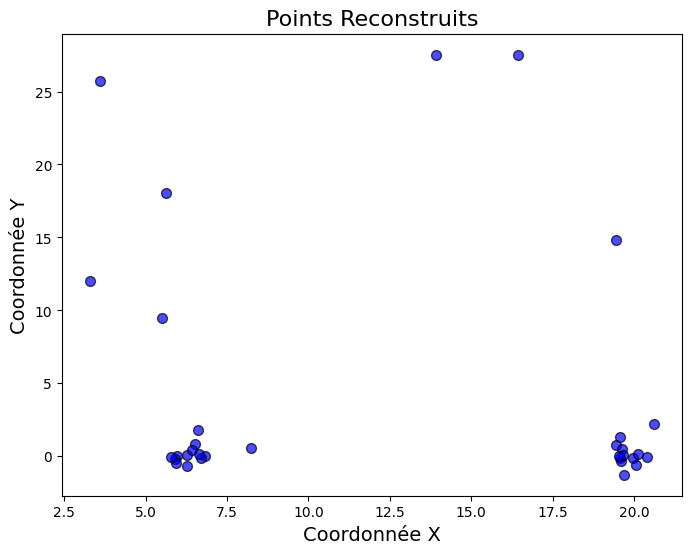

In [80]:
plot_reconstructed_points(float_points)

In [81]:
# Application de K-Means et visualisation
def apply_kmeans_and_plot(float_points, n_clusters):
    """
    Applique K-Means sur les points reconstruits et affiche les clusters ainsi que les métriques.

    Args:
        float_points (list): Liste des points sous forme de tuples de flottants [(X1, Y1), (X2, Y2), ...].
        n_clusters (int): Nombre de clusters pour K-Means.
    """
    # Conversion en tableau NumPy
    points_array = np.array(float_points)

    # Mesurer le temps d'exécution
    start_time = time.time()

    # Initialisation et application de K-Means
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    labels = kmeans.fit_predict(points_array)

    # Mesurer le temps d'exécution
    end_time = time.time()
    execution_time = end_time - start_time

    # Centres des clusters
    cluster_centers = kmeans.cluster_centers_

    # Inertie (somme des distances intra-cluster)
    inertia = kmeans.inertia_

    # Score de silhouette (si plus de 1 cluster)
    if n_clusters > 1:
        silhouette = silhouette_score(points_array, labels)
    else:
        silhouette = None  # Le score de silhouette n'est pas défini pour un seul cluster

    # Afficher les résultats
    print("Centres trouvés par K-Means :")
    print(cluster_centers)
    print("\nInertie (somme des distances intra-cluster) :", inertia)
    if silhouette is not None:
        print("Score de silhouette :", silhouette)
    print(f"\nTemps d'exécution de K-Means : {execution_time:.4f} secondes")

    # Visualisation des clusters
    plt.figure(figsize=(8, 6))
    for cluster_id in range(n_clusters):
        # Sélectionner les points appartenant au cluster actuel
        cluster_points = points_array[labels == cluster_id]
        plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f"Cluster {cluster_id + 1}", s=50, alpha=0.7)

    # Afficher les centres des clusters
    plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1], c='red', s=200, marker='X', label="Centres des Clusters")

    # Ajouter des détails au graphique
    plt.title("Clustering avec K-Means", fontsize=16)
    plt.xlabel("Coordonnée X", fontsize=14)
    plt.ylabel("Coordonnée Y", fontsize=14)
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()

    # Afficher le graphique
    plt.show()
    return kmeans

Centres trouvés par K-Means :
[[19.83854059  0.20829639]
 [ 4.8120513  13.17100684]
 [ 3.61328578 25.71831894]
 [ 6.46783722  0.19324119]
 [15.17902613 27.50621986]
 [19.43523979 14.8049593 ]]

Inertie (somme des distances intra-cluster) : 65.85295194746192
Score de silhouette : 0.7993878343133242

Temps d'exécution de K-Means : 0.0033 secondes


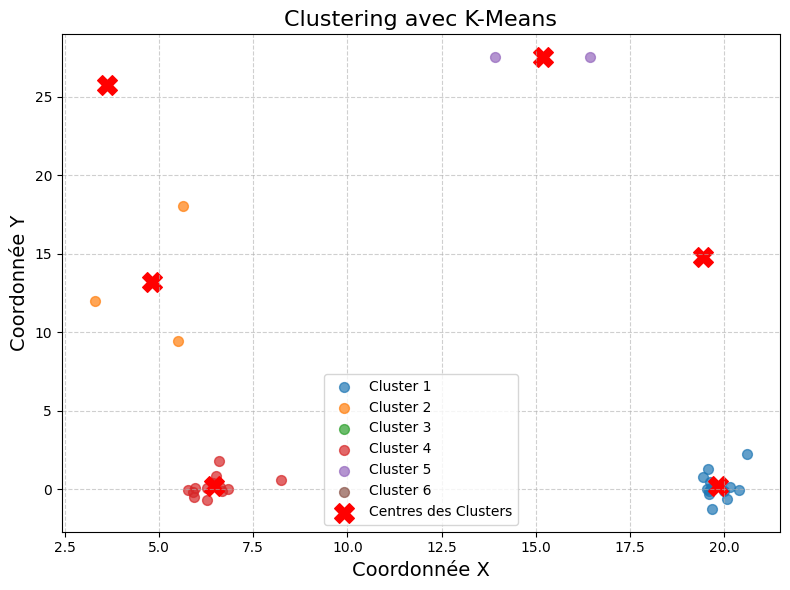

In [82]:
kmeans = apply_kmeans_and_plot(float_points, n_clusters = n_clusters)

/var/folders/5_/x_n3x1nd2qz68t6ylmb7yrhc0000gn/T/ipykernel_58605/2309878381.py:32: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter([x[0] for x in mistakes], [x[1] for x in mistakes], marker='x', c='red', s=60, edgecolors='black', cmap=cmap)
/var/folders/5_/x_n3x1nd2qz68t6ylmb7yrhc0000gn/T/ipykernel_58605/2309878381.py:32: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter([x[0] for x in mistakes], [x[1] for x in mistakes], marker='x', c='red', s=60, edgecolors='black', cmap=cmap)


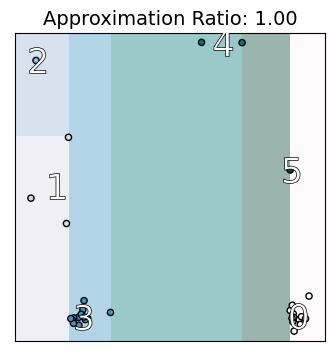

In [83]:
tree = Tree(k=n_clusters)      
tree.fit(float_points, kmeans)               
labels_imm = tree.predict(float_points)
x_data = np.array(float_points, dtype=float)
plot_tree_boundary(tree, n_clusters, x_data, kmeans, plot_mistakes=True)

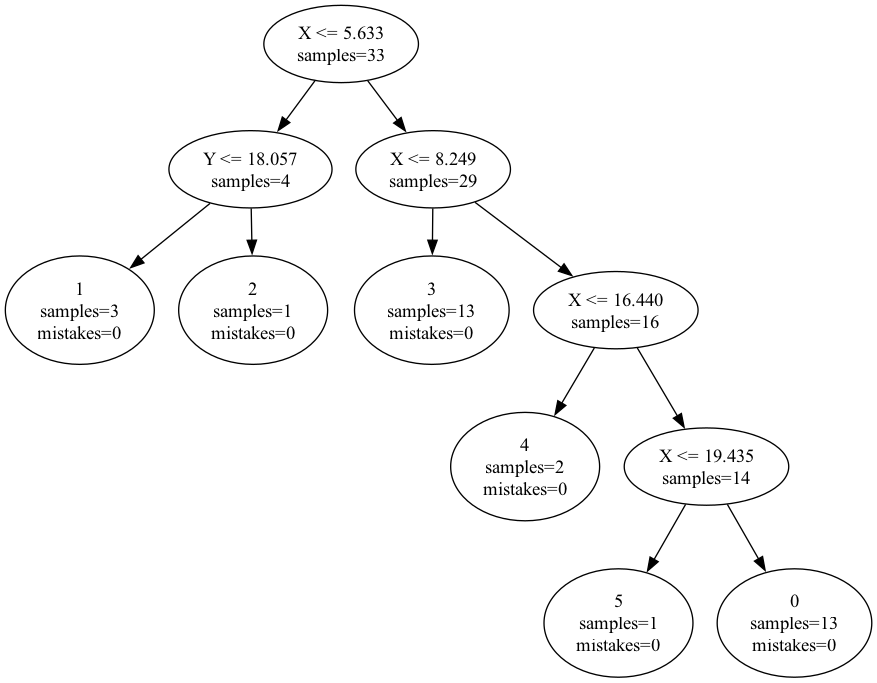

In [84]:
feature_Names = ['X', 'Y']
tree.plot(filename='test1', feature_names=feature_Names)
Image(filename='test1.gv.png')

In [85]:
def apply_kmeans_and_plot_with_tree(float_points, n_clusters):
    """
    Applique K-Means sur les points reconstruits, affiche les clusters et entraîne un arbre de décision
    pour expliquer les regroupements. Affiche également les métriques pertinentes.
    
    Args:
        float_points (list): Liste des points [(X1, Y1), (X2, Y2), ...]
        n_clusters (int): Nombre de clusters
    """
    points_array = np.array(float_points)

    # === K-Means ===
    start_time = time.time()
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    labels = kmeans.fit_predict(points_array)
    end_time = time.time()
    execution_time = end_time - start_time

    inertia = kmeans.inertia_
    silhouette = silhouette_score(points_array, labels) if n_clusters > 1 else None
    cluster_centers = kmeans.cluster_centers_

    # === Decision Tree to explain K-Means ===
    tree_clf = DecisionTreeClassifier(max_depth=4, random_state=42)
    tree_clf.fit(points_array, labels)
    predicted_labels = tree_clf.predict(points_array)
    tree_accuracy = accuracy_score(labels, predicted_labels)

    # === Affichage des métriques ===
    print("Centres trouvés par K-Means :")
    print(cluster_centers)
    print("\nInertie (SSE) :", inertia)
    if silhouette is not None:
        print("Score de silhouette :", silhouette)
    print(f"Temps d'exécution de K-Means : {execution_time:.4f} s")
    print(f"Exactitude de l'arbre de décision (vs K-Means) : {tree_accuracy:.4f}")

    # === Visualisation Clusters ===
    plt.figure(figsize=(8, 6))
    for cluster_id in range(n_clusters):
        cluster_points = points_array[labels == cluster_id]
        plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f"Cluster {cluster_id + 1}", s=50, alpha=0.7)
    plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1], c='red', s=200, marker='X', label="Centres des Clusters")
    plt.title("Clustering avec K-Means", fontsize=16)
    plt.xlabel("Coordonnée X")
    plt.ylabel("Coordonnée Y")
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

    # === Visualisation de l'arbre de décision ===
    plt.figure(figsize=(14, 8))
    plot_tree(tree_clf, filled=True, feature_names=["X", "Y"], class_names=[f"Cluster {i}" for i in range(n_clusters)])
    plt.title("Arbre de décision expliquant le clustering K-Means")
    plt.show()

    return kmeans, tree_clf


Centres trouvés par K-Means :
[[19.83854059  0.20829639]
 [ 4.8120513  13.17100684]
 [ 3.61328578 25.71831894]
 [ 6.46783722  0.19324119]
 [15.17902613 27.50621986]
 [19.43523979 14.8049593 ]]

Inertie (SSE) : 65.85295194746192
Score de silhouette : 0.7993878343133242
Temps d'exécution de K-Means : 0.0109 s
Exactitude de l'arbre de décision (vs K-Means) : 0.9697


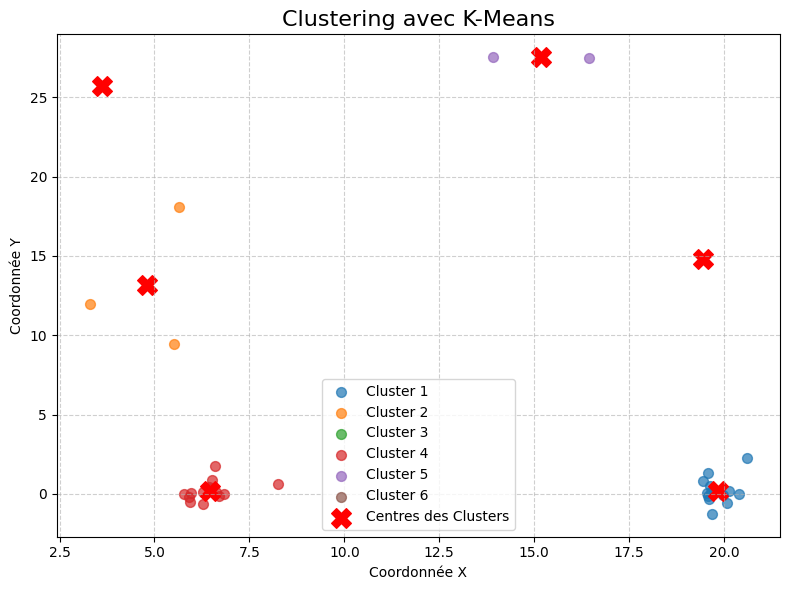

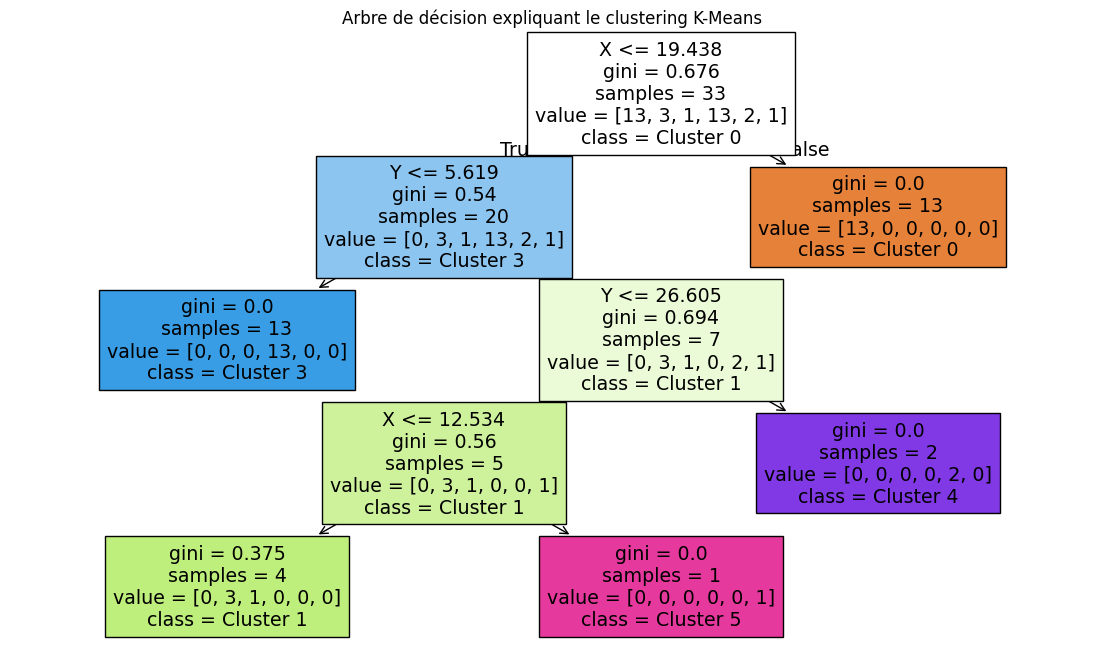

(KMeans(n_clusters=6, random_state=42),
 DecisionTreeClassifier(max_depth=4, random_state=42))

In [86]:
apply_kmeans_and_plot_with_tree(float_points, n_clusters = n_clusters)

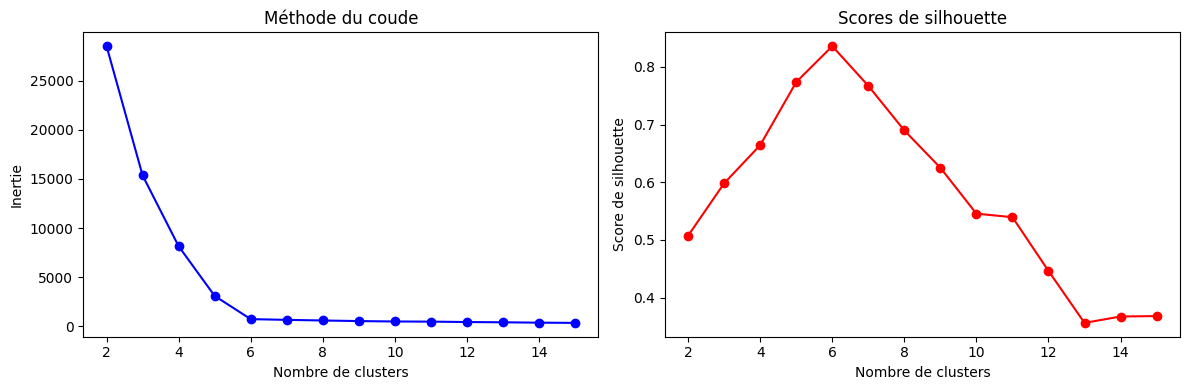

In [87]:
inertias_bis, silhouette_scores_bis = find_optimal_clusters(float_points, max_clusters=15)
plot_metrics(inertias, silhouette_scores)

In [88]:
optimal_k_bis = get_optimal_k_silhouette(silhouette_scores_bis)
print("Nombre optimal de clusters (silhouette) :", optimal_k_bis)

Nombre optimal de clusters (silhouette) : 6


In [89]:
def compute_centroids_with_weights(base_ids, deviations):
    """
    Calcule les centroïdes pour chaque base ID et associe un poids à chaque base.
    Le poids est défini comme le nombre de déviations associées à la base.

    Args:
        base_ids (list): Liste des IDs des bases.
        deviations (list): Liste des déviations associées.

    Returns:
        dict: Dictionnaire contenant les centroïdes pour chaque base ID.
        dict: Dictionnaire contenant les poids pour chaque base ID.
    """
    unique_ids = np.unique(base_ids)
    centroids = {}
    weights = {}

    for uid in unique_ids:
        # Récupérer les indices correspondant à l'ID courant
        indices = [i for i, x in enumerate(base_ids) if x == uid]
        # Extraire les déviations associées
        selected_values = [deviations[i] for i in indices]

        # Convertir en entier, puis calculer la moyenne
        ints = [int(''.join(map(str, val)), 2) for val in selected_values]
        mean_int = round(np.mean(ints))

        # Reconvertir la moyenne en binaire
        mean_bits = [int(x) for x in bin(mean_int)[2:].zfill(len(selected_values[0]))]

        centroids[uid] = mean_bits
        weights[uid] = len(selected_values)

        """
        # Trouver manuellement min et max en comparant bit par bit
        min_val = selected_values[0]
        max_val = selected_values[0]

        for val in selected_values:
            min_val, _ = compare_bitwise(min_val, val)
            _, max_val = compare_bitwise(max_val, val)

        # Calculer la moyenne entre min et max (en entier)
        min_int = int(''.join(map(str, min_val)), 2)
        max_int = int(''.join(map(str, max_val)), 2)
        mean_int = (min_int + max_int) // 2  # Moyenne des deux entiers

        # Convertir la moyenne en binaire
        mean_bin = bin(mean_int)[2:]  # On enlève le préfixe '0b'
        
        # Calculer le centroïde comme la moyenne entre min et max
        centroid = [int(bit) for bit in mean_bin.zfill(len(min_val))]  # Compléter avec des zéros si nécessaire
        centroids[uid] = centroid

        # Associer un poids à la base (nombre de déviations associées)
        weights[uid] = len(selected_values)
        """
    return centroids, weights

# Exemple d'utilisation
centroids_with_weights, weights = compute_centroids_with_weights(base_ids, deviations)
print("Centroids with Weights:", centroids_with_weights)
print("Weights:", weights)

Centroids with Weights: {0: [0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0], 1: [0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0], 2: [0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1], 3: [0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0], 4: [0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0], 5: [0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0], 6: [0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0,

In [90]:
# Reconstruction des points
reconstructed_points_bis = reconstruct_points(base_dict, centroids_with_weights)
print("Reconstructed Points:", reconstructed_points_bis[0])
print("Taille", len(reconstructed_points_bis))

Reconstructed Points: ([0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1], [0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0])
Taille 33


In [91]:
# Conversion des points reconstruits en flottants
float_points_bis = convert_reconstructed_points_to_float(reconstructed_points)

# Affichage des résultats
print("Points reconstruits en flottants :")
for point in float_points:
    print(point)

Points reconstruits en flottants :
(19.435239791870117, 14.804959297180176)
(19.44034767150879, 0.7902253866195679)
(19.986557006835938, -0.09016916155815125)
(19.56849479675293, 1.314173936843872)
(19.581079483032227, -0.13745498657226562)
(19.60039710998535, -0.32038751244544983)
(20.068389892578125, -0.5931053757667542)
(19.62725830078125, 0.4697156548500061)
(19.654987335205078, 0.11177611351013184)
(20.138498306274414, 0.1785399168729782)
(19.551963806152344, 0.03630450740456581)
(20.60919189453125, 2.234693765640259)
(19.682586669921875, -1.2596299648284912)
(20.39127540588379, -0.026829196140170097)
(5.632717132568359, 18.057214736938477)
(5.507950782775879, 9.463951110839844)
(3.613285779953003, 25.718318939208984)
(6.522188663482666, 0.8503459095954895)
(6.265222549438477, 0.11333803087472916)
(5.962429523468018, 0.056383609771728516)
(6.423930644989014, 0.42367613315582275)
(6.603493690490723, 1.774864912033081)
(5.9019341468811035, -0.185868501663208)
(6.828543186187744, 0.0

In [92]:
# Conversion des points reconstruits en flottants
float_points = convert_reconstructed_points_to_float(reconstructed_points_bis)

# Affichage des résultats
print("Points reconstruits en flottants :")
for point in float_points:
    print(point)

Points reconstruits en flottants :
(19.36815071105957, 15.662546157836914)
(19.552282333374023, 0.655619740486145)
(19.926376342773438, -0.10226132720708847)
(19.757593154907227, 1.2671942710876465)
(19.72102928161621, -0.24711120128631592)
(19.404054641723633, -0.4462379813194275)
(20.26453971862793, -0.867772102355957)
(19.702476501464844, 0.43028825521469116)
(19.654987335205078, 0.11177611351013184)
(20.100889205932617, 0.14533016085624695)
(19.551963806152344, 0.03630450740456581)
(20.60919189453125, 2.234694004058838)
(19.75959587097168, -1.9108052253723145)
(20.39127540588379, -0.026829196140170097)
(5.523209571838379, 23.904613494873047)
(4.984117031097412, 10.296611785888672)
(3.6543972492218018, 28.51764488220215)
(6.591036796569824, 0.715602695941925)
(6.096832275390625, 0.06715550273656845)
(5.962429523468018, 0.056383609771728516)
(6.1764702796936035, 0.25905847549438477)
(6.405494689941406, 1.4873273372650146)
(6.410207748413086, -0.13355617225170135)
(6.828543186187744, 

In [93]:
def apply_kmeans_with_weights_and_plot(float_points, weights, n_clusters):
    """
    Applique K-Means sur les points reconstruits en tenant compte des poids et affiche les clusters ainsi que les métriques.

    Args:
        float_points (list): Liste des points sous forme de tuples de flottants [(X1, Y1), (X2, Y2), ...].
        weights (dict): Dictionnaire contenant les poids associés à chaque base ID.
        n_clusters (int): Nombre de clusters pour K-Means.
    """
    # Conversion en tableau NumPy
    points_array = np.array(float_points)

    # Création d'un tableau de poids aligné avec les points
    weight_array = np.array([weights[base_id] for base_id in range(len(float_points))])

    # Mesurer le temps d'exécution
    start_time = time.time()

    # Initialisation et application de K-Means avec les poids
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    labels = kmeans.fit_predict(points_array, sample_weight=weight_array)

    # Mesurer le temps d'exécution
    end_time = time.time()
    execution_time = end_time - start_time

    # Centres des clusters
    cluster_centers = kmeans.cluster_centers_

    # Inertie (somme des distances intra-cluster)
    inertia = kmeans.inertia_

    # Score de silhouette (sans poids, car non supporté)
    if n_clusters > 1:
        silhouette = silhouette_score(points_array, labels)
    else:
        silhouette = None  # Le score de silhouette n'est pas défini pour un seul cluster

    # Afficher les résultats
    print("Centres trouvés par K-Means :")
    print(cluster_centers)
    print("\nInertie (somme des distances intra-cluster) :", inertia)
    if silhouette is not None:
        print("Score de silhouette :", silhouette)
    print(f"\nTemps d'exécution de K-Means : {execution_time:.4f} secondes")

    # Visualisation des clusters
    plt.figure(figsize=(8, 6))
    for cluster_id in range(n_clusters):
        # Sélectionner les points appartenant au cluster actuel
        cluster_points = points_array[labels == cluster_id]
        plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f"Cluster {cluster_id + 1}", s=50, alpha=0.7)

    # Afficher les centres des clusters
    plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1], c='red', s=200, marker='X', label="Centres des Clusters")

    # Ajouter des détails au graphique
    plt.title("Clustering avec K-Means (avec poids)", fontsize=16)
    plt.xlabel("Coordonnée X", fontsize=14)
    plt.ylabel("Coordonnée Y", fontsize=14)
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()

    # Afficher le graphique
    plt.show()
    return kmeans

Centres trouvés par K-Means :
[[ 5.42882511 24.13759488]
 [ 6.4419347   0.57092321]
 [19.28295461 15.77067127]
 [ 4.73378104 10.31965044]
 [19.75740425  0.48608268]
 [14.49123764 28.35485077]]

Inertie (somme des distances intra-cluster) : 324.63384678284586
Score de silhouette : 0.8320888297591209

Temps d'exécution de K-Means : 0.0066 secondes


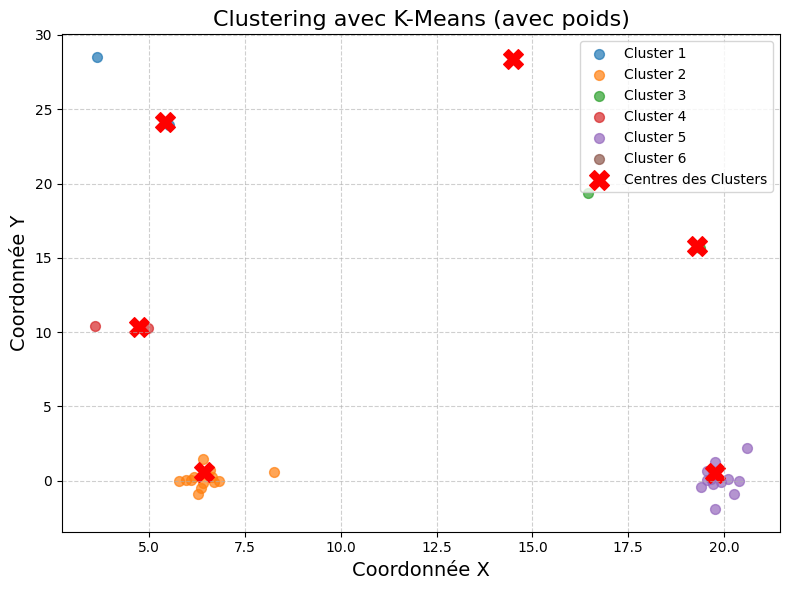

In [94]:
kmeans = apply_kmeans_with_weights_and_plot(float_points, weights, n_clusters=n_clusters)

/var/folders/5_/x_n3x1nd2qz68t6ylmb7yrhc0000gn/T/ipykernel_58605/2309878381.py:32: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter([x[0] for x in mistakes], [x[1] for x in mistakes], marker='x', c='red', s=60, edgecolors='black', cmap=cmap)
/var/folders/5_/x_n3x1nd2qz68t6ylmb7yrhc0000gn/T/ipykernel_58605/2309878381.py:32: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter([x[0] for x in mistakes], [x[1] for x in mistakes], marker='x', c='red', s=60, edgecolors='black', cmap=cmap)


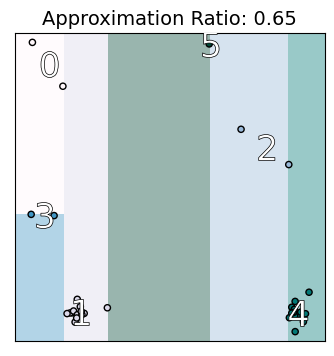

In [95]:
# IMM ALgorithm applied to the Kmean 
tree = Tree(k=n_clusters)      
tree.fit(float_points, kmeans)               
labels_imm = tree.predict(float_points)
x_data = np.array(float_points, dtype=float)
plot_tree_boundary(tree,n_clusters, x_data, kmeans, plot_mistakes=True)

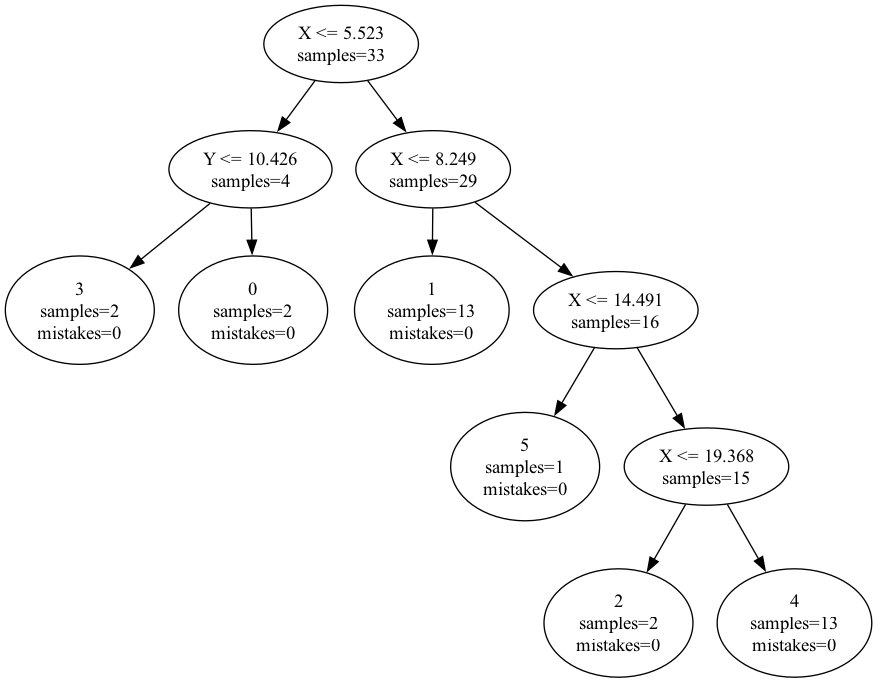

In [96]:
feature_Names = ['X', 'Y']
tree.plot(filename='test3', feature_names=feature_Names)
Image(filename='test3.gv.png')

In [97]:
def apply_kmeans_with_weights_and_tree(float_points, weights, n_clusters):
    """
    Applique K-Means avec poids, affiche les clusters, et entraîne un arbre de décision
    pour expliquer les regroupements K-Means.
    """
    # === Conversion des données ===
    points_array = np.array(float_points)
    weight_array = np.array([weights[base_id] for base_id in range(len(float_points))])

    # === K-Means avec poids ===
    start_time = time.time()
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    labels = kmeans.fit_predict(points_array, sample_weight=weight_array)
    end_time = time.time()
    execution_time = end_time - start_time
    inertia = kmeans.inertia_
    silhouette = silhouette_score(points_array, labels) if n_clusters > 1 else None
    cluster_centers = kmeans.cluster_centers_

    # === Arbre de décision ===
    tree_clf = DecisionTreeClassifier(max_depth=4, random_state=42)
    tree_clf.fit(points_array, labels, sample_weight=weight_array)
    predicted_labels = tree_clf.predict(points_array)
    tree_accuracy = accuracy_score(labels, predicted_labels)

    # === Affichage des métriques ===
    print("Centres trouvés par K-Means :")
    print(cluster_centers)
    print("\nInertie (SSE) :", inertia)
    if silhouette is not None:
        print("Score de silhouette :", silhouette)
    print(f"Temps d'exécution de K-Means : {execution_time:.4f} s")
    print(f"Exactitude de l'arbre de décision (vs K-Means) : {tree_accuracy:.4f}")

    # === Visualisation des clusters ===
    plt.figure(figsize=(8, 6))
    for cluster_id in range(n_clusters):
        cluster_points = points_array[labels == cluster_id]
        plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f"Cluster {cluster_id + 1}", s=50, alpha=0.7)
    plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1], c='red', s=200, marker='X', label="Centres des Clusters")
    plt.title("Clustering avec K-Means (poids)", fontsize=16)
    plt.xlabel("Coordonnée X")
    plt.ylabel("Coordonnée Y")
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

    # === Visualisation de l'arbre de décision ===
    plt.figure(figsize=(14, 8))
    plot_tree(tree_clf, filled=True, feature_names=["X", "Y"], class_names=[f"Cluster {i}" for i in range(n_clusters)])
    plt.title("Arbre de décision expliquant le clustering pondéré")
    plt.show()

    return kmeans, tree_clf


Centres trouvés par K-Means :
[[ 5.42882511 24.13759488]
 [ 6.4419347   0.57092321]
 [19.28295461 15.77067127]
 [ 4.73378104 10.31965044]
 [19.75740425  0.48608268]
 [14.49123764 28.35485077]]

Inertie (SSE) : 324.63384678284586
Score de silhouette : 0.8320888297591209
Temps d'exécution de K-Means : 0.0127 s
Exactitude de l'arbre de décision (vs K-Means) : 1.0000


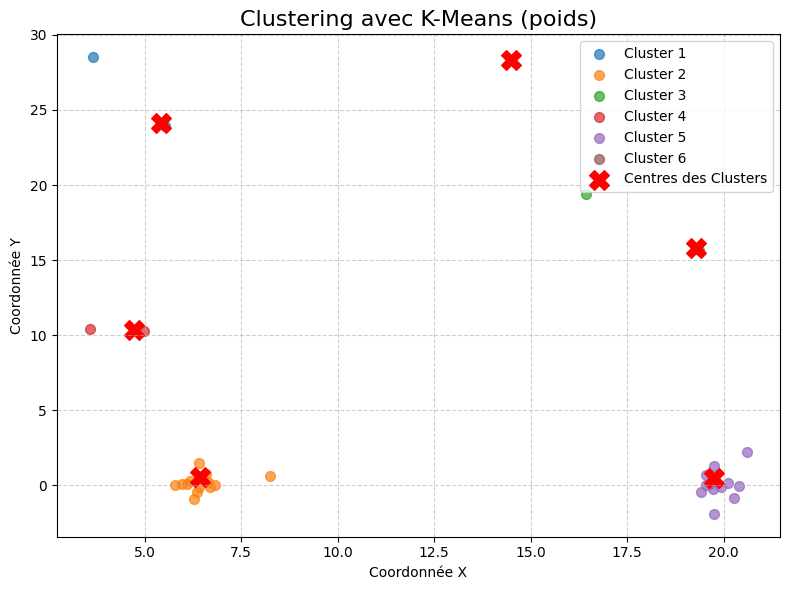

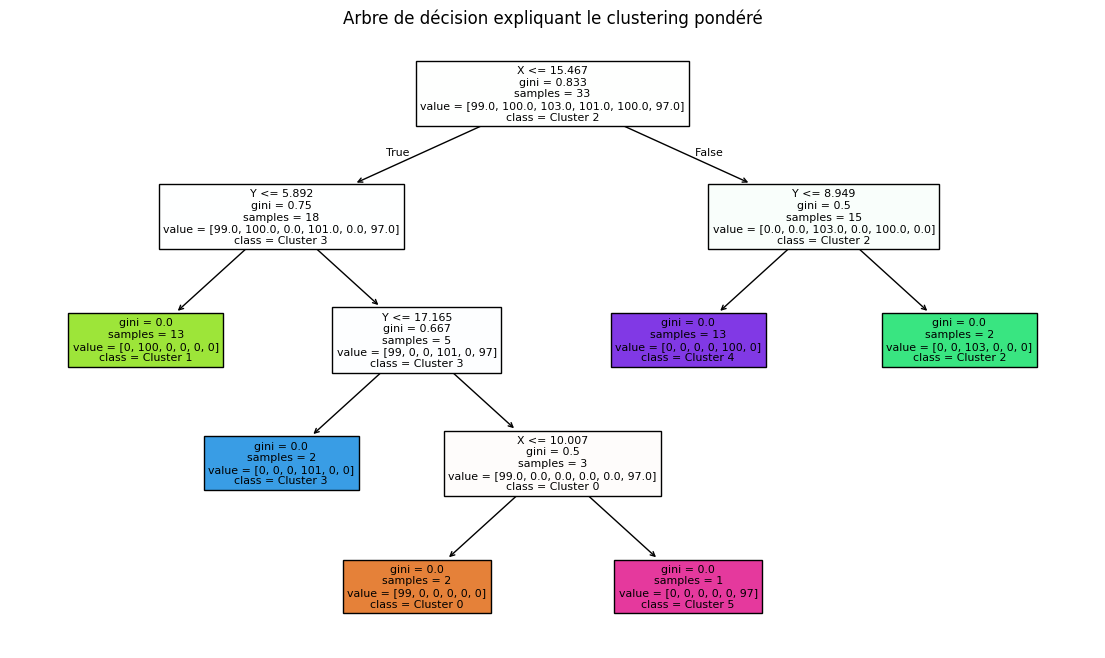

(KMeans(n_clusters=6, random_state=42),
 DecisionTreeClassifier(max_depth=4, random_state=42))

In [98]:
apply_kmeans_with_weights_and_tree(float_points, weights, n_clusters=n_clusters)

In [99]:
def compute_weighted_centroids(base_dict, base_ids, deviations, base_bits=9):
    unique_ids = np.unique(base_ids)
    centroids = {}
    max_of_max_deviations = {}
    mean_of_max_deviations = {}
    prod_of_max_deviations = {}

    id_to_bases = {uid: [] for uid in unique_ids}
    for base, bid in base_dict.items():
        if bid in id_to_bases:
            id_to_bases[bid].append(base)

    for uid in unique_ids:
        base_tuple = id_to_bases[uid][0]  # base = 18 bits (9 + 9)
        base_x = list(base_tuple[:base_bits])
        base_y = list(base_tuple[base_bits:2 * base_bits])
        base_bits_full = base_x + base_y  # 18 bits

        # Récupérer les déviations (46 bits) associées à l'uid
        indices = [i for i, x in enumerate(base_ids) if x == uid]
        selected_deviations = [deviations[i] for i in indices]

        # Initialisation
        min_dev = selected_deviations[0]
        max_dev = selected_deviations[0]

        for dev in selected_deviations:
            min_dev, _ = compare_bitwise(min_dev, dev)
            _, max_dev = compare_bitwise(max_dev, dev)

        # Moyenne bitwise sur l'ensemble des 46 bits
        min_int = int(''.join(map(str, min_dev)), 2)
        max_int = int(''.join(map(str, max_dev)), 2)
        mean_int = (min_int + max_int) // 2
        mean_dev_bin = bin(mean_int)[2:].zfill(46)
        mean_dev = [int(b) for b in mean_dev_bin]

        # Centroïde complet = base_x + base_y + moyenne des déviations
        centroid = mean_dev
        centroids[uid] = centroid

        # Pour le poids "max of max" : concat base_x + max_dev_x, base_y + max_dev_y
        max_dev_x = [val[:23] for val in selected_deviations]
        max_dev_y = [val[23:] for val in selected_deviations]

        # Trouver les plus grandes déviations X et Y
        max_dx = max_dev_x[0]
        max_dy = max_dev_y[0]
        for dx, dy in zip(max_dev_x, max_dev_y):
            _, max_dx = compare_bitwise(max_dx, dx)
            _, max_dy = compare_bitwise(max_dy, dy)

        # Concat binaire
        base_x_str = ''.join(map(str, base_x))
        base_y_str = ''.join(map(str, base_y))
        max_dx_str = ''.join(map(str, max_dx))
        max_dy_str = ''.join(map(str, max_dy))

        concat_x = int(base_x_str + max_dx_str, 2)
        concat_y = int(base_y_str + max_dy_str, 2)
        
        maximum_weight = concat_x if concat_x > concat_y else concat_y
        mean_weight = (concat_x + concat_y)//2
        prod_weight = (concat_x * concat_y)//1000000

        max_of_max_deviations[uid] = maximum_weight
        mean_of_max_deviations[uid] = mean_weight
        prod_of_max_deviations[uid] = prod_weight//10000

        #print(f"UID: {uid}, Centroid: {centroid}, MaxWeight: , MeanWeight: {mean_weight:.4f}, ProdWeight: {prod_weight:.4f}")

    return centroids, max_of_max_deviations, mean_of_max_deviations, prod_of_max_deviations


In [100]:
print("Calcul des centroids et de leur poids ")
centroids2, max_of_max, mean_of_max, prod_of_max= compute_weighted_centroids(base_dict, base_ids, deviations)
reconstructed_points_2 = reconstruct_points(base_dict, centroids2)
float_points = convert_reconstructed_points_to_float(reconstructed_points_2)

print("Centroids: ", float_points)
print("Weigths max of max: ", max_of_max)
print("Weigths mean of max: ", mean_of_max)
print("Weigths product of max: ",prod_of_max)

Calcul des centroids et de leur poids 
Centroids:  [(19.435239791870117, 14.804959297180176), (19.44034767150879, 0.7902253866195679), (19.986557006835938, -0.09016916155815125), (19.56849479675293, 1.314173936843872), (19.581079483032227, -0.13745498657226562), (19.60039710998535, -0.32038751244544983), (20.068389892578125, -0.5931053757667542), (19.62725830078125, 0.4697156548500061), (19.654987335205078, 0.11177611351013184), (20.138498306274414, 0.1785399168729782), (19.551963806152344, 0.03630450740456581), (20.60919189453125, 2.234693765640259), (19.682586669921875, -1.2596299648284912), (20.39127540588379, -0.026829196140170097), (5.632717132568359, 18.057214736938477), (5.507950782775879, 9.463951110839844), (3.613285779953003, 25.718318939208984), (6.522188663482666, 0.8503459095954895), (6.265222549438477, 0.11333803087472916), (5.962429523468018, 0.056383609771728516), (6.423930644989014, 0.42367613315582275), (6.603493690490723, 1.774864912033081), (5.9019341468811035, -0.1

K-means sur les maximum de déviation
Méthode 1: Moyennne des Maximums de déviations
Centres trouvés par K-Means :
[[1.98531042e+01 1.66290187e-02]
 [6.37194265e+00 5.93461168e-02]
 [4.62461875e+00 2.18816313e+01]
 [1.51789579e+01 2.75062206e+01]
 [1.94352398e+01 1.48049593e+01]
 [4.40399538e+00 1.07253013e+01]]

Inertie (somme des distances intra-cluster) : 71484690943.28983
Score de silhouette : 0.8112387453168382

Temps d'exécution de K-Means : 0.0029 secondes


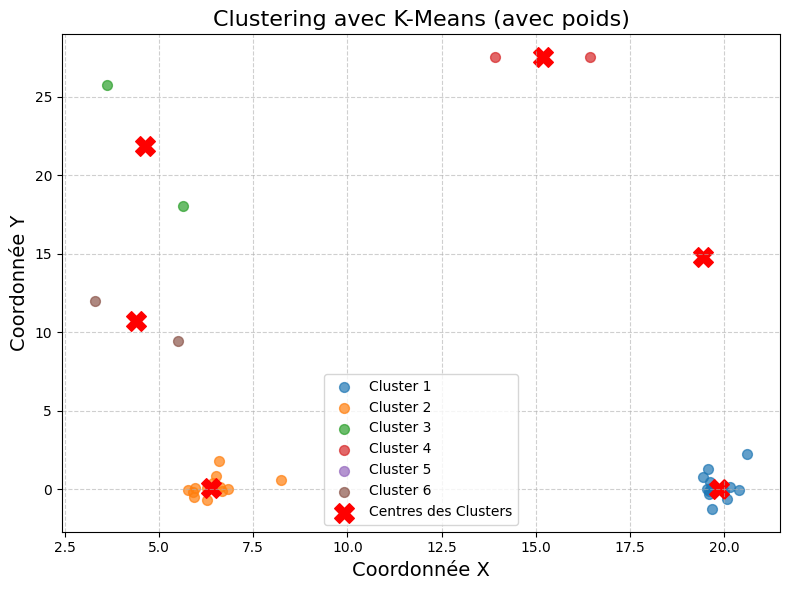

KMeans(n_clusters=6, random_state=42)

In [101]:
print("K-means sur les maximum de déviation")
print("Méthode 1: Moyennne des Maximums de déviations")
apply_kmeans_with_weights_and_plot(float_points, mean_of_max, n_clusters=n_clusters)

Méthode 2: produit des des de déviations
Centres trouvés par K-Means :
[[ 1.98609540e+01 -8.66463771e-02]
 [ 6.31624217e+00 -1.85075499e-02]
 [ 4.62625996e+00  2.18754051e+01]
 [ 1.51788910e+01  2.75062214e+01]
 [ 1.94352398e+01  1.48049593e+01]
 [ 4.40628598e+00  1.07226841e+01]]

Inertie (somme des distances intra-cluster) : 8256306637.708396
Score de silhouette : 0.8112387453168382

Temps d'exécution de K-Means : 0.0028 secondes


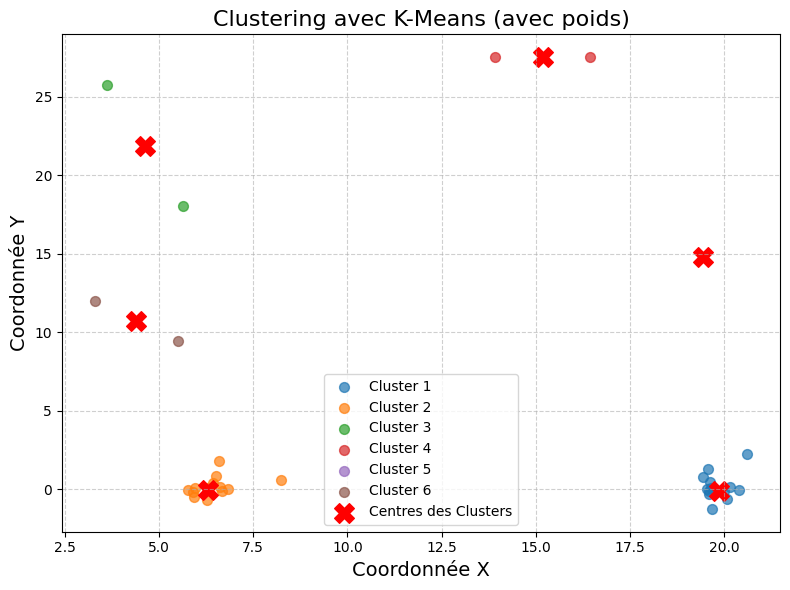

KMeans(n_clusters=6, random_state=42)

In [102]:
print("Méthode 2: produit des des de déviations")
apply_kmeans_with_weights_and_plot(float_points, prod_of_max, n_clusters=n_clusters)

Méthode 3: Maximum des maximums de deviations
Centres trouvés par K-Means :
[[ 1.98596487e+01 -7.95007004e-02]
 [ 6.32025369e+00 -1.44105399e-02]
 [ 4.62298815e+00  2.18878173e+01]
 [ 1.51783697e+01  2.75062273e+01]
 [ 1.94352398e+01  1.48049593e+01]
 [ 4.40283473e+00  1.07266274e+01]]

Inertie (somme des distances intra-cluster) : 76250891404.46207
Score de silhouette : 0.8112387453168382

Temps d'exécution de K-Means : 0.0043 secondes


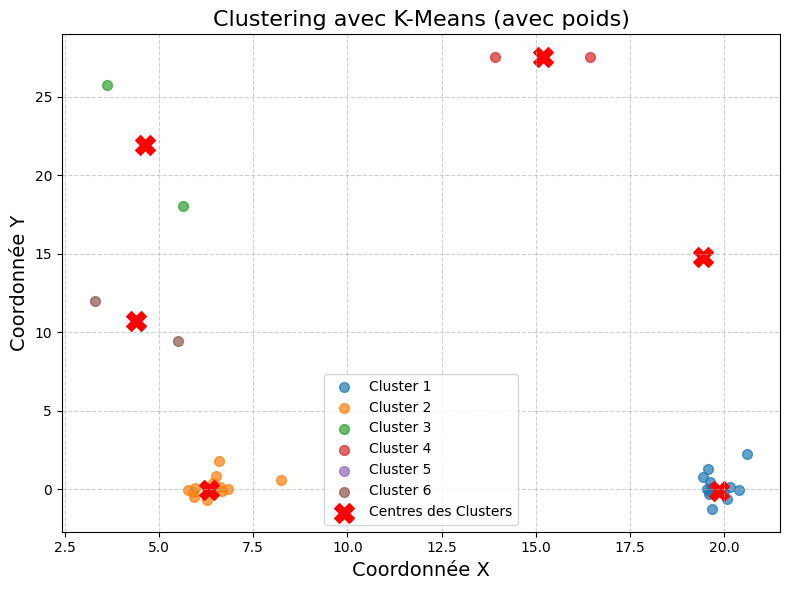

KMeans(n_clusters=6, random_state=42)

In [103]:
print("Méthode 3: Maximum des maximums de deviations")
apply_kmeans_with_weights_and_plot(float_points, max_of_max, n_clusters=n_clusters)